In [57]:
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from geopy.point import Point
from geopy.distance import great_circle
from math import radians, degrees, sin, cos, atan2, sqrt
import networkx as nx
import matplotlib.cm as cm
from pyproj import Transformer

In [2]:
def midpoint(lat1, lon1, lat2, lon2):
    # Converta as latitudes e longitudes de graus para radianos
    lat1, lon1 = radians(lat1), radians(lon1)
    lat2, lon2 = radians(lat2), radians(lon2)

    # Converta para coordenadas cartesianas
    x1, y1, z1 = cos(lat1) * cos(lon1), cos(lat1) * sin(lon1), sin(lat1)
    x2, y2, z2 = cos(lat2) * cos(lon2), cos(lat2) * sin(lon2), sin(lat2)

    # Calcule a média das coordenadas cartesianas
    x_mid = (x1 + x2) / 2
    y_mid = (y1 + y2) / 2
    z_mid = (z1 + z2) / 2

    # Converta de volta para coordenadas geográficas
    lon_mid = atan2(y_mid, x_mid)
    hyp = sqrt(x_mid * x_mid + y_mid * y_mid)
    lat_mid = atan2(z_mid, hyp)

    # Converta de radianos para graus
    return degrees(lat_mid), degrees(lon_mid)

In [3]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Constante: raio da Terra em quilômetros
    R = 6371.0

    # Converter graus em radianos
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Diferença de coordenadas
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Fórmula de Haversine
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Distância em quilômetros
    distance = R * c*1000
    return distance

In [200]:
data = np.loadtxt("./output/resultados_2.dat")
nodes = np.loadtxt("./file/nodes_2.txt")
edges = np.loadtxt("./file/edges_2.txt")

In [140]:
edges

array([[0.000000e+00, 1.000000e+00, 1.680000e+02, 1.234830e-01],
       [0.000000e+00, 1.180000e+02, 2.796000e+03, 2.047367e+00],
       [1.000000e+00, 6.200000e+01, 2.644000e+03, 1.936417e+00],
       ...,
       [4.680000e+02, 4.310000e+02, 2.750000e+02, 4.040000e-01],
       [4.680000e+02, 4.670000e+02, 8.570000e+02, 1.256400e+00],
       [4.690000e+02, 4.510000e+02, 1.261000e+03, 9.238500e-01]])

In [112]:
distance_edges = []
for node1,node2 in edges[:,:2].astype(int):
    point1 = Point(nodes[node1][1], nodes[node1][2])
    point2 = Point(nodes[node2][1], nodes[node2][2])

    center = midpoint(nodes[node1][1], nodes[node1][2], nodes[node2][1], nodes[node2][2])
    distance_edges.append([node1,node2,center[0],center[1]])
distance_edges = np.array(distance_edges)

In [113]:
distance_edges[5]

array([  3.       , 416.       , -38.514584 ,  -3.7368665])

In [191]:
t = np.abs(data[900])
dist = np.array([haversine_distance(distance_edges[2][2],distance_edges[2][3],i[2],i[3]) for i in distance_edges])
bins = 400
dt = (np.max(t) - np.min(t))/bins
bars = np.arange(np.min(t),np.max(t)+dt,dt)
hist = np.array([0]*len(bars))

for dado in t:
    for j in range(len(bars)):
        if(dado<bars[j]):
            break
    hist[j] += 1
bars = bars[hist > 0]
hist = hist[hist > 0]
hist = hist/np.sum(hist)

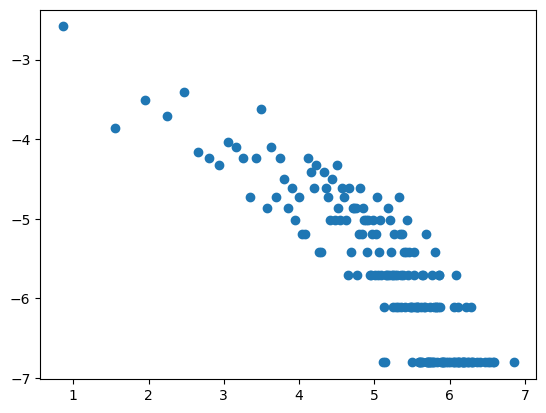

In [207]:
plt.scatter(np.log(bars),np.log(hist))
plt.show()

/tmp/ipykernel_69785/552146249.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(dist,np.log(t))


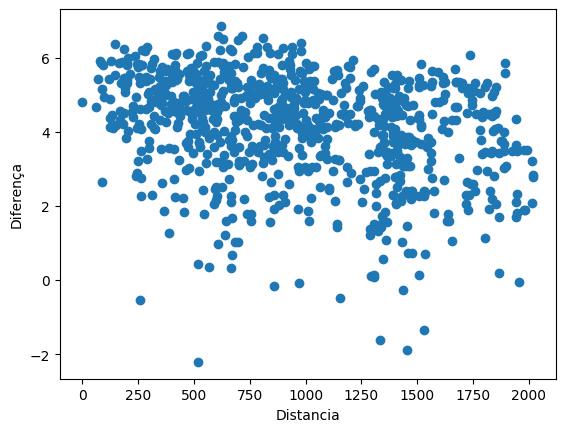

In [193]:

plt.scatter(dist,np.log(t))
plt.xlabel("Distancia")
plt.ylabel("Diferença")
plt.show()

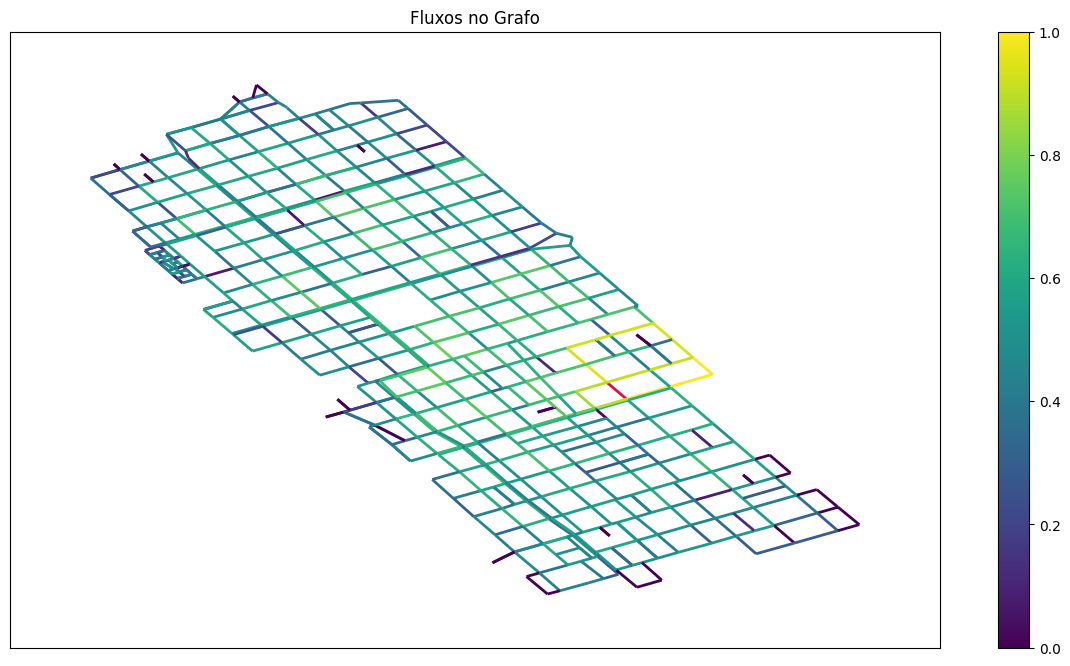

In [208]:
transformer = Transformer.from_crs("epsg:4326", "epsg:32633")

nos = np.array([[no[0], transformer.transform(no[1],no[2])[0], transformer.transform(no[1],no[2])[1]]for no in nodes])
G = nx.DiGraph()

# Adicionando nós com posições baseadas nas coordenadas
for node in nos:
    G.add_node(int(node[0]), pos=(node[1], node[2]))
for i in edges:
    G.add_edge(int(i[0]), int(i[1]))
lig = 2
weights = np.abs(data[lig])+0.1
weights = np.log(weights)
norm = plt.Normalize(min(weights), max(weights))

# Mapeando os pesos para cores usando o colormap 'viridis'
edge_colors = [cm.viridis(norm(weight)) for weight in weights]
edge_colors[lig] = 'crimson'
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(15, 8))
ax = nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2, arrows=False)
plt.colorbar(ax)
plt.title('Fluxos no Grafo')
plt.show()

In [203]:
nx.reciprocity(G)

0.2286348501664817

In [49]:
import pandas as pd
skewness = []
for i in data:
    df = pd.DataFrame({'valores': i})

    # Calcular a skewness
    skewness.append(df['valores'].skew())

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  3.,  3.,  1.,  2.,  5.,  7.,  2.,  4.,
         1.,  1.,  1.,  7.,  4.,  3.,  2.,  3.,  1.,  2.,  0.,  3.,  2.,
         2.,  2.,  4.,  2.,  3.,  2.,  1.,  3.,  4.,  1.,  3.,  6.,  1.,
         6.,  1.,  3.,  4.,  7.,  3.,  5.,  6.,  3.,  3.,  4.,  5.,  1.,
         8.,  6.,  6.,  7.,  7.,  6.,  5.,  6.,  8.,  1., 11.,  2.,  4.,
         1.,  4.,  3., 10.,  7., 10.,  6.,  4., 11., 10., 11., 12., 10.,
        15.,  5.,  9., 14., 13., 23., 15., 12., 14., 21., 21., 28., 16.,
        15., 13., 23., 15., 12., 18., 16., 12.,  6.,  9.,  9.,  8., 31.,
        11.,  9.,  8.,  7.,  8.,  5.,  3.,  4., 10., 12.,  4.,  3.,  2.,
         7.,  6.,  8.,  6.,  4.,  2.,  1.,  9.,  4.,  2.,  5.,  7.,  2.,
         4.,  2.,  3.,  2.,  4.,  1.,  3.,  1.,  4.

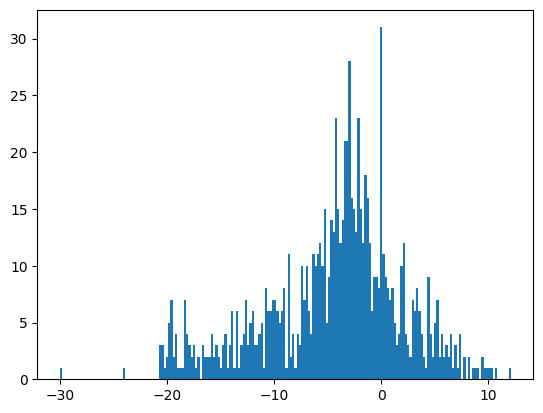

In [52]:
plt.hist(skewness,bins = 200)

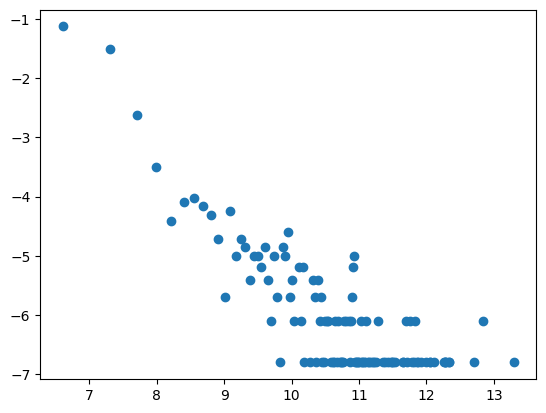

In [58]:
plt.scatter(np.log(bars),np.log(hist))
plt.show()

Coeficiente de determinação (R^2): 0.911905555590631
Intercepto (b0): 9.923691612550845
Coeficiente (b1): -1.6474385276867705


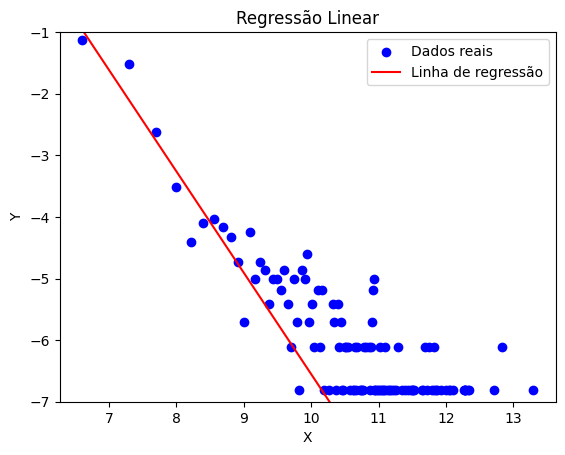

In [42]:
from sklearn.linear_model import LinearRegression

x = np.log(bars)  # Reshape para formato 2D necessário para scikit-learn
y = np.log(hist)

y_ = y[x<9]
x_ = x[x<9]
x_ = x_.reshape(-1,1)
model = LinearRegression()  # Criação do modelo
model.fit(x_, y_)  # Ajuste do modelo aos dados
r_sq = model.score(x_, y_)
y_pred = model.predict(x.reshape(-1,1))

print(f"Coeficiente de determinação (R^2): {r_sq}")
print(f"Intercepto (b0): {model.intercept_}")
print(f"Coeficiente (b1): {model.coef_[0]}")

plt.scatter(x, y, color='blue', label='Dados reais')
plt.plot(x, y_pred, color='red', label='Linha de regressão')
plt.title('Regressão Linear')
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim(-7,-1)
plt.legend()
plt.show()

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          2.,   2.,   2.,   1.,   1.,   0.,   0.,   3.,   4.,   0.,   2.,
          6.,   2.,   5.,   2.,   6., 

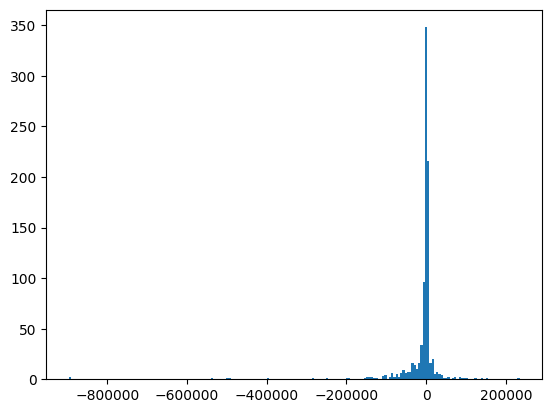

In [6]:
plt.hist(data[1],bins = 200)